In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats 
import seaborn as sns
import statsmodels.formula.api as smf
import scikit_posthocs as sp
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
plt.rc("font", size=14)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import BoundaryNorm, ListedColormap

In [6]:
# columns = ['noun', 'adj', 'propn', 'adv', 'intj', 'cconj', 'sconj', 'adp', 'det', 'num', 'punct', 'symbol', 'pron', 'abbr', 'TTR', 'avg_word_len', 'avr_sent_len', 'hapax_legomena', 'coref', 'see_pron', 'see_det', '1st_pron', '2nd_pron', '3rd_pron', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', '3rd_prs_verb', 'core_verb', 'verbtype_ratio', 'da_inf', 'gerund', 'supine', 'verb_particle', 'discourse', 'pres_tense', 'past_tense', 'ind_mood', 'cond_mood', 'imp_mood', 'quot_mood', 'neg_polarity', 'nom_case', 'gen_case', 'part_case', 'ill_case', 'ine_case', 'ela_case', 'alla_case', 'ade_case', 'abl_case', 'tra_case', 'ter_case', 'ess_case', 'abe_case', 'com_case', 'nsubj', 'nsubj_cop', 'modal', 'acl:relc', 'csubj', 'csubj_cop', 'obj', 'ccomp', 'xcomp', 'obl', 'nmod', 'appos', 'nummod', 'amod', 'advcl', 'voc', 'cop', 'conj', 'cc', 'yneemid', 'emoticons']
columns = ['file_id', 'noun', 'adj', 'propn', 'adv', 'intj', 'cconj', 'sconj', 'adp', 'det', 'num', 'punct', 'symbol', 'pron', 'abbr', 'nominals', 'TTR', 'avg_word_len', 'avr_sent_len', 'hapax_legomena', 'pron/noun_ratio', 'see_pron', 'see_det', '1st_pron', '2nd_pron', '3rd_pron', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', '3rd_prs_verb', 'core_verb', 'verbtype_ratio', 'da_inf', 'inf_verb', 'finite_verb' ,'gerund', 'supine', 'verb_particle', 'discourse', 'pres_tense', 'past_tense', 'ind_mood', 'cond_mood', 'imp_mood', 'quot_mood', 'neg_polarity', 'nom_case', 'gen_case', 'part_case', 'ill_case', 'ine_case', 'ela_case', 'alla_case', 'ade_case', 'abl_case', 'tra_case', 'ter_case', 'ess_case', 'abe_case', 'com_case', 'nsubj', 'nsubj_cop', 'modal', 'acl:relc', 'csubj', 'csubj_cop', 'obj', 'ccomp', 'xcomp', 'obl', 'nmod', 'appos', 'nummod', 'amod', 'advcl', 'voc', 'cop', 'conj', 'cc', 'yneemid', 'emoticons']

def get_data(f):
    ls = []
    with open(f, 'r') as fid:
        reader = csv.DictReader(fid, delimiter=';')
        data = [line for line in reader]
        
    return data


### FUNKTSIOONIDE SEKTSIOON

In [12]:
def create_array(data):
    # KW sisendi saamiseks on vaja iga rea (=faili) tunnuste väärtused ehk
    # [[tunnus11, tunnus12,.., tunnus1N], [tunnus21, tunnus22,.., tunnus2N], ..]
    d = [list(line.items()) for line in data]
    arrays = []
    for f in d:
        arrays.append([element[1] for element in f[1:]])
    return np.array(arrays)

In [13]:
def calculate_hb(rank):
    # holm-bonferroni meetodil p väärtuse korrigeerimine, tavalaks on 0.05, aga siin oleme liberaalsed ja panime 0.1
    adjusted_p = 0.1 / (78 - rank + 1)
    return adjusted_p

In [14]:
def get_relevant_features(f, p):
    # tagastab listide listi, kus igas listis on [tunnus, järjekorra nr, KW p, korrigeeritud p, saatus]
    features = [[feature, round(p, 5), f] for feature, f, p in zip(columns, f.tolist(), p.tolist())]       
    H_statistics = [feature[2] for feature in features]
    p_values = [feature[1] for feature in features]
    ranks = stats.rankdata(p_values)
    features = [feature[0] for feature in features]
    m = [s for s in zip(features, p_values, H_statistics, ranks)]
    positive_features = [] 
    for el in m:
        kW_p = el[1]
        adjusted_p = calculate_hb(el[3])
        if adjusted_p > kW_p:
            state = 'YES'
        else:
            state = 'NO'
        positive_features.append([el[0], el[3], el[2], kW_p, adjusted_p, state])

    return positive_features  

In [15]:
def calculate_dunn_test2(feature, strong_pd, weak_pd, not_pres_pd):
    data = [strong_pd[feature], weak_pd[feature], notpres_pd[feature]]
    df = pd.DataFrame(data).transpose()

    # gruppide määramine ehk tugev/mõõdukas; nõrk; not_present
    group1 = df.iloc[:, 0].dropna()
    group2 = df.iloc[:, 1].dropna()
    group3 = df.iloc[:, 2].dropna()
    
    dunn = sp.posthoc_dunn([group1, group2, group3], p_adjust='holm')
#         dunn = sp.posthoc_dunn([group1, group2, group3])

    return feature.upper(), dunn


In [19]:
def generate_df(strong_array, weak_array, notpres_array):
    # Kruskal Wallise väljund
    f_statistic, p_value = stats.kruskal(strong_array, weak_array, notpres_array)
    feature_data = get_relevant_features(f_statistic, p_value)

    return feature_data, pd.DataFrame(feature_data, columns =['feature', 'rank', 'H statistic', 'KW p', 'adjusted p', 'state'])

    

In [20]:
def display_posthoc_results(feats, strong, weak, notpres):
    """sisend: tunnused, tugev-mõõdukas, nõrk, puudu dataframe'id.
    siin funktsioonis kasutatakse calculate_dunn_test2 funktsiooni, kus siis tunnus tunnuse haaval vaadatakse konkreetselt ühe tunnuse 
    mõõtmisi kolmes grupis ja arvutatakse, milliste gruppide vahel on erinevusi.
    väljund: list -> tugev-mõõdukas, tugev-puudu, nõrk-puudu grupid per tunnus (kui relevantne tunnuse p on dunni testis <=0.05) 
    """
    
    strong_w = []
    strong_not = []
    weak_not = []
    for feat in feats:
        out = calculate_dunn_test2(feat, strong, weak, notpres)
        print(f'\n{out[0]}\n{out[1]}')
        print('Kui p>0.05, siis need jäetakse välja!\n')
        strong_weak = [out[1].iloc[1, 0], 'tugev/mõõdukas vs nõrk']
        strong_notpres = [out[1].iloc[2, 0], 'tugev/mõõdukas vs puudu']
        weak_notpres = [out[1].iloc[2, 1], 'nõrk vs puudu']
        for score in [strong_weak, strong_notpres, weak_notpres]:
            if score[0] <= 0.05:
                if score[1] == 'tugev/mõõdukas vs nõrk':
                    print('GRUPP 1 (tugev/mõõdukas vs nõrk)')
                    print(f'{feat}, {round(score[0], 10)} \n')
                    strong_w.append([feat, round(score[0], 10)])
                    
                if score[1] == 'tugev/mõõdukas vs puudu':
                    print('GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)')
                    print(f'{feat}, {round(score[0], 10)} \n')
                    strong_not.append([feat, round(score[0], 10)])
                if score[1] == 'nõrk vs puudu':
                    print('GRUPP 3 (nõrk vs MITTEEKSISTEERIV)')
                    print(f'{feat}, {round(score[0], 10)} \n')
                    weak_not.append([feat, round(score[0], 10)])
                print(f'TUGEV/MÕÕDUKAS -> mediaan/keskmine: {round(strong[feat].median(), 3)}; {round(strong[feat].mean(), 3)}')
                print(f'NÕRK -> mediaan/keskmine: {round(weak[feat].median(), 3)}; {round(weak[feat].mean(), 3)}')
                print(f'MITTEEKSISTEERIV -> mediaan/keskmine: {round(notpres[feat].median(), 3)}; {round(notpres[feat].mean(), 3)}')


                # print(f'{feat.upper()} =>\n {score[1]}, {round(score[0], 4)}')
            print('================')
    return strong_w, strong_not, weak_not

### INSTRUEERIVUS

In [28]:
f1 = 'dimensioonide_grupid/inst/inst_strong.csv'
f2 = 'dimensioonide_grupid/inst/inst_weak.csv'
f3 = 'dimensioonide_grupid/inst/inst_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)


print(f'"tugev/mõõdukas" kokku -> {len(strong)}')
print(f'"nõrk" kokku -> {len(weak)}')
print(f'"puudu" kokku -> {len(notpres)}')


feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

"tugev/mõõdukas" kokku -> 15
"nõrk" kokku -> 18
"puudu" kokku -> 58


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,19.0,5.997210,0.04986,0.001667,NO
1,adj,58.0,1.372091,0.50356,0.004762,NO
2,propn,9.0,10.179264,0.00616,0.001429,NO
3,adv,27.0,5.319493,0.06997,0.001923,NO
4,intj,75.5,0.199667,0.90499,0.028571,NO
5,cconj,32.0,4.484371,0.10623,0.002128,NO
6,sconj,53.0,1.579174,0.45403,0.003846,NO
7,adp,49.0,1.924492,0.38203,0.003333,NO
8,det,77.0,0.086687,0.95758,0.050000,NO
9,num,40.0,2.714762,0.25733,0.002564,NO


In [29]:
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

for r in relevant_feats:
    print(r)

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

pres_tense

PRES_TENSE
          1         2         3
1  1.000000  0.684228  0.001032
2  0.684228  1.000000  0.001824
3  0.001032  0.001824  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
pres_tense, 0.0010315064 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.116; 0.115
NÕRK -> mediaan/keskmine: 0.108; 0.106
MITTEEKSISTEERIV -> mediaan/keskmine: 0.071; 0.071
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
pres_tense, 0.0018241219 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.116; 0.115
NÕRK -> mediaan/keskmine: 0.108; 0.106
MITTEEKSISTEERIV -> mediaan/keskmine: 0.071; 0.071


### ABSTRAKTSUS

In [30]:
f1 = 'dimensioonide_grupid/abs/abs_strong.csv'
f2 = 'dimensioonide_grupid/abs/abs_weak.csv'
f3 = 'dimensioonide_grupid/abs/abs_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)

print(f'"tugev/mõõdukas" kokku -> {len(strong)}')
print(f'"nõrk" kokku -> {len(weak)}')
print(f'"puudu" kokku -> {len(notpres)}')

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[5] == 'YES']

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

print(relevant_feats)

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

"tugev/mõõdukas" kokku -> 6
"nõrk" kokku -> 36
"puudu" kokku -> 56


,feature,rank,H statistic,KW p,adjusted p,state
0,noun,31.0,6.142325,0.04637,0.002083,NO
1,adj,43.0,3.914883,0.14122,0.002778,NO
2,propn,42.0,4.065174,0.13100,0.002703,NO
3,adv,27.0,6.532556,0.03815,0.001923,NO
4,intj,5.5,54.801663,0.00000,0.001361,YES
5,cconj,64.0,1.169079,0.55736,0.006667,NO
6,sconj,51.0,2.391473,0.30248,0.003571,NO
7,adp,49.0,2.470180,0.29081,0.003333,NO
8,det,30.0,6.144291,0.04632,0.002041,NO
9,num,38.0,5.473630,0.06478,0.002439,NO


['intj', 'symbol', '2nd_pron', 'discourse', 'imp_mood', 'quot_mood', 'abl_case', 'ter_case', 'abe_case', 'csubj', 'csubj_cop', 'obl', 'voc', 'yneemid', 'emoticons']

INTJ
     1    2    3
1  1.0  1.0  1.0
2  1.0  1.0  1.0
3  1.0  1.0  1.0
Kui p>0.05, siis need jäetakse välja!


SYMBOL
          1         2         3
1  1.000000  0.783403  0.783403
2  0.783403  1.000000  0.783403
3  0.783403  0.783403  1.000000
Kui p>0.05, siis need jäetakse välja!


2ND_PRON
          1         2         3
1  1.000000  0.765263  0.286397
2  0.765263  1.000000  0.059813
3  0.286397  0.059813  1.000000
Kui p>0.05, siis need jäetakse välja!


DISCOURSE
     1    2    3
1  1.0  1.0  1.0
2  1.0  1.0  1.0
3  1.0  1.0  1.0
Kui p>0.05, siis need jäetakse välja!


IMP_MOOD
          1         2         3
1  1.000000  0.962507  0.942034
2  0.962507  1.000000  0.528712
3  0.942034  0.528712  1.000000
Kui p>0.05, siis need jäetakse välja!


QUOT_MOOD
     1    2    3
1  1.0  1.0  1.0
2  1.0  1.0  1.0
3  1.0  1.0  

### AFEKTIIVSUS

In [113]:
f1 = 'dimensioonide_grupid/afek/afek_strong.csv'
f2 = 'dimensioonide_grupid/afek/afek_weak.csv'
f3 = 'dimensioonide_grupid/afek/afek_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)

pd.DataFrame(strong)[['xcomp', 'file_id']]

# print(f'"tugev/mõõdukas" kokku -> {len(strong)}')
# print(f'"nõrk" kokku -> {len(weak)}')
# print(f'"puudu" kokku -> {len(notpres)}')

# feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df)


# relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']

# strong_pd = pd.read_csv(f1, sep=';')
# weak_pd = pd.read_csv(f2, sep=';')
# notpres_pd = pd.read_csv(f3, sep=';')

# print(relevant_feats)

# res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

,xcomp,file_id
0,0.015625,ylle_mrt_ee.ela_101705
1,0.03137254901960784,valitsus_ee.ela_480708
2,0.021212121212121213,www_mulje_ee.ela_177932
3,0.0,uudised_err_ee.ela_541051
4,0.041666666666666664,www_lapsemure_ee.ela_140896
5,0.007518796992481203,unitedkiters_ee.ela_78733
6,0.0196078431372549,toompark_pri_ee.ela_458650
7,0.01948051948051948,www_auto24_ee.ela_469677
8,0.0273972602739726,www_delfi_ee.ela_361703
9,0.028368794326241134,rahvahaal_delfi_ee.ela_388979


### AEG

In [71]:
f1 = 'dimensioonide_grupid/aeg/aeg_strong.csv'
f2 = 'dimensioonide_grupid/aeg/aeg_weak.csv'
f3 = 'dimensioonide_grupid/aeg/aeg_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)

print(len(strong))
print(len(weak))
print(len(notpres))

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

print(relevant_feats)

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

16
39
19


,feature,rank,KW p,adjusted p,state
0,noun,73.0,0.83411,0.016667,NO
1,adj,63.0,0.64618,0.006250,NO
2,propn,9.0,0.01225,0.001429,NO
3,adv,45.0,0.29196,0.002941,NO
4,intj,26.5,0.15760,0.001905,NO
5,cconj,37.5,0.24640,0.002410,NO
6,sconj,18.0,0.09044,0.001639,NO
7,adp,69.0,0.66537,0.010000,NO
8,det,30.0,0.18689,0.002041,NO
9,num,5.0,0.00341,0.001351,NO


['da_inf', 'pres_tense', 'past_tense', 'nummod']

DA_INF
          1         2         3
1  1.000000  0.011486  0.000284
2  0.011486  1.000000  0.071271
3  0.000284  0.071271  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
da_inf, 0.0114856217 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.009; 0.009
NÕRK -> mediaan/keskmine: 0.017; 0.02
MITTEEKSISTEERIV -> mediaan/keskmine: 0.026; 0.025
GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
da_inf, 0.0002838366 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.009; 0.009
NÕRK -> mediaan/keskmine: 0.017; 0.02
MITTEEKSISTEERIV -> mediaan/keskmine: 0.026; 0.025

PRES_TENSE
          1         2         3
1  1.000000  0.002708  0.000085
2  0.002708  1.000000  0.093619
3  0.000085  0.093619  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
pres_tense, 0.0027083704 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.031; 0.047
NÕRK -> mediaan/keskmine: 0.088; 0.086
MITTEEKSISTEERIV -> mediaan/keskmine: 0.11; 0.105

### ARGUMENTATIIVSUS

In [72]:
f1 = 'dimensioonide_grupid/arg/arg_strong_emoticons.csv'
f2 = 'dimensioonide_grupid/arg/arg_weak_emoticons.csv'
f3 = 'dimensioonide_grupid/arg/arg_not_present_emoticons.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)


# print(len(strong))
# print(len(weak))
# print(len(notpres))

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

    
relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

print(relevant_feats)

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

,feature,rank,KW p,adjusted p,state
0,noun,46.0,0.27359,0.003030,NO
1,adj,40.0,0.23324,0.002564,NO
2,propn,3.0,0.00043,0.001316,YES
3,adv,39.0,0.19915,0.002500,NO
4,intj,73.5,0.81804,0.018182,NO
5,cconj,48.0,0.28862,0.003226,NO
6,sconj,20.0,0.06028,0.001695,NO
7,adp,63.0,0.59528,0.006250,NO
8,det,37.0,0.19030,0.002381,NO
9,num,26.0,0.08826,0.001887,NO


['propn', 'da_inf', 'pres_tense', 'past_tense', 'neg_polarity']

PROPN
          1         2         3
1  1.000000  0.231327  0.000532
2  0.231327  1.000000  0.013760
3  0.000532  0.013760  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
propn, 0.000531673 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.02; 0.032
NÕRK -> mediaan/keskmine: 0.038; 0.047
MITTEEKSISTEERIV -> mediaan/keskmine: 0.076; 0.09
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
propn, 0.0137603004 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.02; 0.032
NÕRK -> mediaan/keskmine: 0.038; 0.047
MITTEEKSISTEERIV -> mediaan/keskmine: 0.076; 0.09

DA_INF
          1         2         3
1  1.000000  0.999051  0.003872
2  0.999051  1.000000  0.002610
3  0.003872  0.002610  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
da_inf, 0.0038717156 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.025; 0.026
NÕRK -> mediaan/keskmine: 0.021; 0.025
MITTEEKSISTEERIV -> mediaan/keskmi

### FORMAALSUS

In [77]:
f1 = 'dimensioonide_grupid/form/form_strong_emoticons.csv'
f2 = 'dimensioonide_grupid/form/form_weak_emoticons.csv'
f3 = 'dimensioonide_grupid/form/form_not_present_emoticons.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)

print(len(strong))
print(len(weak))
print(len(notpres))

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']
print(relevant_feats)


strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

14
28
49


,feature,rank,KW p,adjusted p,state
0,noun,5.5,0.00000,0.001361,YES
1,adj,22.0,0.00087,0.001754,YES
2,propn,14.0,0.00014,0.001538,YES
3,adv,5.5,0.00000,0.001361,YES
4,intj,44.5,0.07976,0.002899,NO
5,cconj,52.0,0.12085,0.003704,NO
6,sconj,27.0,0.00238,0.001923,NO
7,adp,73.0,0.69060,0.016667,NO
8,det,12.5,0.00012,0.001504,YES
9,num,39.0,0.03563,0.002500,NO


['noun', 'adj', 'propn', 'adv', 'det', 'punct', 'pron', 'avg_word_len', 'avr_sent_len', 'coref', '1st_pron', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'verbtype_ratio', 'ind_mood', 'imp_mood', 'gen_case', 'nsubj_cop', 'xcomp', 'nmod', 'cop']

NOUN
          1         2         3
1  1.000000  0.114095  0.000005
2  0.114095  1.000000  0.000173
3  0.000005  0.000173  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 5.3796e-06 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.335; 0.347
NÕRK -> mediaan/keskmine: 0.299; 0.302
MITTEEKSISTEERIV -> mediaan/keskmine: 0.245; 0.242
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0001730261 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.335; 0.347
NÕRK -> mediaan/keskmine: 0.299; 0.302
MITTEEKSISTEERIV -> mediaan/keskmine: 0.245; 0.242

ADJ
          1         2         3
1  1.000000  0.008966  0.000535
2  0.008966  1.000000  0.385642
3  0.000535  0.385642  1.000000
Kui p>0.05, siis n

### IMPERSONAALSUS

In [78]:
f1 = 'dimensioonide_grupid/imp/imp_strong.csv'
f2 = 'dimensioonide_grupid/imp/imp_weak.csv'
f3 = 'dimensioonide_grupid/imp/imp_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)


print(len(strong))
print(len(weak))
print(len(notpres))

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']
print(relevant_feats)

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

37
21
28


,feature,rank,KW p,adjusted p,state
0,noun,4.5,0.00000,0.001342,YES
1,adj,16.0,0.00051,0.001587,YES
2,propn,37.0,0.07755,0.002381,NO
3,adv,9.5,0.00001,0.001439,YES
4,intj,21.5,0.00137,0.001739,YES
5,cconj,59.0,0.32321,0.005000,NO
6,sconj,29.0,0.00906,0.002000,NO
7,adp,67.0,0.47570,0.008333,NO
8,det,19.0,0.00077,0.001667,YES
9,num,48.0,0.13464,0.003226,NO


['noun', 'adj', 'adv', 'intj', 'det', 'pron', 'abbr', 'avg_word_len', 'coref', '1st_pron', '2nd_pron', '3rd_pron', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'verbtype_ratio', 'supine', 'discourse', 'ind_mood', 'imp_mood', 'gen_case', 'xcomp', 'nmod']

NOUN
              1         2             3
1  1.000000e+00  0.000986  7.810205e-10
2  9.864760e-04  1.000000  2.876591e-02
3  7.810205e-10  0.028766  1.000000e+00
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
noun, 0.000986476 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.321; 0.328
NÕRK -> mediaan/keskmine: 0.262; 0.263
MITTEEKSISTEERIV -> mediaan/keskmine: 0.216; 0.214
GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 8e-10 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.321; 0.328
NÕRK -> mediaan/keskmine: 0.262; 0.263
MITTEEKSISTEERIV -> mediaan/keskmine: 0.216; 0.214
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0287659082 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.321; 0.328
NÕRK -> media

### INFOTIHEDUS

In [79]:
f1 = 'dimensioonide_grupid/info/info_strong.csv'
f2 = 'dimensioonide_grupid/info/info_weak.csv'
f3 = 'dimensioonide_grupid/info/info_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)

print(len(strong))
print(len(weak))
print(len(notpres))

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']
print(relevant_feats)

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

45
26
5


,feature,rank,KW p,adjusted p,state
0,noun,14.0,0.00068,0.001538,YES
1,adj,33.0,0.03403,0.002174,NO
2,propn,24.0,0.01136,0.001818,NO
3,adv,13.0,0.00040,0.001515,YES
4,intj,22.5,0.00949,0.001770,NO
5,cconj,64.0,0.65293,0.006667,NO
6,sconj,15.0,0.00440,0.001563,NO
7,adp,51.0,0.22675,0.003571,NO
8,det,16.0,0.00460,0.001587,NO
9,num,10.5,0.00006,0.001460,YES


['noun', 'adv', 'num', 'pron', 'avg_word_len', 'coref', '1st_pron', '2nd_pron', '1st_prs_verb', '2nd_prs_verb', 'imp_mood', 'neg_polarity', 'xcomp', 'nummod']

NOUN
          1         2         3
1  1.000000  0.002513  0.027851
2  0.002513  1.000000  0.490774
3  0.027851  0.490774  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
noun, 0.0025134747 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.302; 0.3
NÕRK -> mediaan/keskmine: 0.236; 0.247
MITTEEKSISTEERIV -> mediaan/keskmine: 0.219; 0.23
GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 0.0278508216 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.302; 0.3
NÕRK -> mediaan/keskmine: 0.236; 0.247
MITTEEKSISTEERIV -> mediaan/keskmine: 0.219; 0.23

ADV
          1         2         3
1  1.000000  0.000531  0.099573
2  0.000531  1.000000  0.998293
3  0.099573  0.998293  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
adv, 0.0005307072 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.063; 0.071
NÕ

### INTERAKTIIVSUS

In [80]:
f1 = 'dimensioonide_grupid/inter/inter_strong.csv'
f2 = 'dimensioonide_grupid/inter/inter_weak.csv'
f3 = 'dimensioonide_grupid/inter/inter_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)

print(len(strong))
print(len(weak))
print(len(notpres))

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']
print(relevant_feats)

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

10
15
75


,feature,rank,KW p,adjusted p,state
0,noun,7.0,0.00001,0.001389,YES
1,adj,25.0,0.00420,0.001852,NO
2,propn,26.0,0.00480,0.001887,NO
3,adv,18.0,0.00177,0.001639,NO
4,intj,8.5,0.00004,0.001418,YES
5,cconj,78.0,0.96369,0.100000,NO
6,sconj,35.0,0.02819,0.002273,NO
7,adp,49.5,0.16392,0.003390,NO
8,det,48.0,0.15517,0.003226,NO
9,num,34.0,0.02727,0.002222,NO


['noun', 'intj', 'pron', 'TTR', 'avg_word_len', 'hapax_legomena', 'coref', '1st_pron', '2nd_pron', '1st_prs_verb', '2nd_prs_verb', 'discourse', 'imp_mood', 'neg_polarity', 'gen_case', 'nmod', 'voc']

NOUN
          1         2         3
1  1.000000  0.522908  0.000532
2  0.522908  1.000000  0.000798
3  0.000532  0.000798  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 0.0005316103 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.212; 0.205
NÕRK -> mediaan/keskmine: 0.227; 0.222
MITTEEKSISTEERIV -> mediaan/keskmine: 0.286; 0.289
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0007983047 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.212; 0.205
NÕRK -> mediaan/keskmine: 0.227; 0.222
MITTEEKSISTEERIV -> mediaan/keskmine: 0.286; 0.289

INTJ
          1         2         3
1  1.000000  0.026642  0.000033
2  0.026642  1.000000  0.096095
3  0.000033  0.096095  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
intj, 0.0266418773 

T

### KEERULISUS

In [81]:
f1 = 'dimensioonide_grupid/keer/keer_strong_emoticons.csv'
f2 = 'dimensioonide_grupid/keer/keer_weak_emoticons.csv'
f3 = 'dimensioonide_grupid/keer/keer_not_present_emoticons.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)

print(len(strong))
print(len(weak))
print(len(notpres))

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']
print(relevant_feats)

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

9
25
53


,feature,rank,KW p,adjusted p,state
0,noun,16.0,0.01065,0.001587,NO
1,adj,22.0,0.01994,0.001754,NO
2,propn,25.0,0.02839,0.001852,NO
3,adv,26.0,0.03028,0.001887,NO
4,intj,38.5,0.13004,0.002469,NO
5,cconj,74.0,0.82388,0.020000,NO
6,sconj,46.0,0.16686,0.003030,NO
7,adp,61.0,0.52861,0.005556,NO
8,det,37.0,0.12714,0.002381,NO
9,num,47.0,0.17091,0.003125,NO


['punct', 'abbr', '1st_pron', '1st_prs_verb', 'core_verb', 'nmod']

PUNCT
          1         2         3
1  1.000000  0.637972  0.016343
2  0.637972  1.000000  0.004476
3  0.016343  0.004476  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
punct, 0.0163434264 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.118; 0.127
NÕRK -> mediaan/keskmine: 0.125; 0.126
MITTEEKSISTEERIV -> mediaan/keskmine: 0.148; 0.148
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
punct, 0.0044760158 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.118; 0.127
NÕRK -> mediaan/keskmine: 0.125; 0.126
MITTEEKSISTEERIV -> mediaan/keskmine: 0.148; 0.148

ABBR
          1         2         3
1  1.000000  0.054014  0.000676
2  0.054014  1.000000  0.054014
3  0.000676  0.054014  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
abbr, 0.0006755665 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.054; 0.045
NÕRK -> mediaan/keskmine: 0.008; 0.017
MITTEEKSISTEERIV -> mediaan/ke

### SPONTAANSUS

In [82]:
f1 = 'dimensioonide_grupid/spont/spont_strong.csv'
f2 = 'dimensioonide_grupid/spont/spont_weak.csv'
f3 = 'dimensioonide_grupid/spont/spont_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)


print(len(strong))
print(len(weak))
print(len(notpres))

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']
print(relevant_feats)

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

12
6
79


,feature,rank,KW p,adjusted p,state
0,noun,4.0,0.00000,0.001333,YES
1,adj,36.0,0.03028,0.002326,NO
2,propn,19.0,0.00054,0.001667,YES
3,adv,9.5,0.00001,0.001439,YES
4,intj,4.0,0.00000,0.001333,YES
5,cconj,65.0,0.44997,0.007143,NO
6,sconj,46.0,0.11811,0.003030,NO
7,adp,58.0,0.31165,0.004762,NO
8,det,52.0,0.18464,0.003704,NO
9,num,40.0,0.07267,0.002564,NO


['noun', 'propn', 'adv', 'intj', 'pron', 'avg_word_len', 'coref', '1st_pron', '2nd_pron', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'discourse', 'imp_mood', 'neg_polarity', 'gen_case', 'nsubj_cop', 'obl', 'nmod', 'cop']

NOUN
          1         2         3
1  1.000000  0.473671  0.000009
2  0.473671  1.000000  0.020539
3  0.000009  0.020539  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 9.2864e-06 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.212; 0.198
NÕRK -> mediaan/keskmine: 0.231; 0.237
MITTEEKSISTEERIV -> mediaan/keskmine: 0.296; 0.296
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0205386879 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.212; 0.198
NÕRK -> mediaan/keskmine: 0.231; 0.237
MITTEEKSISTEERIV -> mediaan/keskmine: 0.296; 0.296

PROPN
          1         2         3
1  1.000000  0.618473  0.001343
2  0.618473  1.000000  0.095346
3  0.001343  0.095346  1.000000
Kui p>0.05, siis need jäetakse välja!

GRUPP 2 (tugev/mõõdukas vs MITTE

### SUBJEKTIIVSUS

In [110]:
f1 = 'dimensioonide_grupid/subj/subj_strong.csv'
f2 = 'dimensioonide_grupid/subj/subj_weak.csv'
f3 = 'dimensioonide_grupid/subj/subj_not_present.csv'

# kruskall Wallise sisendid (kolm gruppi)
strong = get_data(f1)
weak = get_data(f2)
notpres = get_data(f3)

print(len(strong))
print(len(weak))
print(len(notpres))

feature_data, df = generate_df(create_array(strong), create_array(weak), create_array(notpres))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)
    
relevant_feats = [feat[0] for feat in feature_data if feat[4] == 'YES']
print(relevant_feats)

strong_pd = pd.read_csv(f1, sep=';')
weak_pd = pd.read_csv(f2, sep=';')
notpres_pd = pd.read_csv(f3, sep=';')

res1, res2, res3 = display_posthoc_results(relevant_feats, strong_pd, weak_pd, notpres_pd)

30
15
52


,feature,rank,KW p,adjusted p,state
0,noun,7.5,0.00000,0.001399,YES
1,adj,23.0,0.00042,0.001786,YES
2,propn,7.5,0.00000,0.001399,YES
3,adv,7.5,0.00000,0.001399,YES
4,intj,21.5,0.00039,0.001739,YES
5,cconj,76.0,0.79353,0.033333,NO
6,sconj,30.0,0.00202,0.002041,YES
7,adp,69.0,0.71770,0.010000,NO
8,det,34.0,0.00273,0.002222,NO
9,num,54.0,0.26488,0.004000,NO


['noun', 'adj', 'propn', 'adv', 'intj', 'sconj', 'punct', 'pron', 'avg_word_len', 'coref', 'see_pron', '1st_pron', '2nd_pron', 'active_voice', 'passive_voice', '1st_prs_verb', '2nd_prs_verb', 'core_verb', 'supine', 'discourse', 'ind_mood', 'imp_mood', 'neg_polarity', 'gen_case', 'ade_case', 'nsubj_cop', 'csubj_cop', 'obl', 'nmod', 'amod', 'cop']

NOUN
              1         2             3
1  1.000000e+00  0.032324  2.339419e-09
2  3.232403e-02  1.000000  2.478731e-02
3  2.339419e-09  0.024787  1.000000e+00
Kui p>0.05, siis need jäetakse välja!

GRUPP 1 (tugev/mõõdukas vs nõrk)
noun, 0.0323240309 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.224; 0.217
NÕRK -> mediaan/keskmine: 0.263; 0.263
MITTEEKSISTEERIV -> mediaan/keskmine: 0.306; 0.311
GRUPP 2 (tugev/mõõdukas vs MITTEEKSISTEERIV)
noun, 2.3e-09 

TUGEV/MÕÕDUKAS -> mediaan/keskmine: 0.224; 0.217
NÕRK -> mediaan/keskmine: 0.263; 0.263
MITTEEKSISTEERIV -> mediaan/keskmine: 0.306; 0.311
GRUPP 3 (nõrk vs MITTEEKSISTEERIV)
noun, 0.0247873084 

## KORRELATSIOONID

In [23]:
input_f = 'limesurvey_feature_results_w_dims_uus.csv'

data = []

with open(input_f, 'r') as fid:
    csv_reader = csv.DictReader(fid, delimiter=',')
    fieldnames = csv_reader.fieldnames
    for line in csv_reader:
        data.append(line)

In [24]:
initial_df = pd.DataFrame(data).iloc[:, 1:].astype(float)

In [25]:
initial_df

,abs,afek,aeg,arg,form,imp,info,inst,inter,keer,...,appos,nummod,amod,advcl,voc,cop,conj,cc,yneemid,emoticons
0,1.35,0.85,0.65,1.55,0.70,1.80,1.10,0.90,0.45,0.50,...,0.015873,0.039683,0.031746,0.000000,0.0,0.015873,0.071429,0.055556,0.0,0.0
1,0.65,1.15,0.70,0.65,0.45,0.65,1.15,0.75,0.70,0.65,...,0.008000,0.028000,0.044000,0.000000,0.0,0.012000,0.068000,0.040000,0.0,0.0
2,1.25,1.65,0.15,1.50,0.15,0.55,0.35,0.60,0.85,0.40,...,0.000000,0.000000,0.041916,0.029940,0.0,0.035928,0.095808,0.047904,0.0,0.0
3,0.60,1.20,0.80,1.85,0.45,1.15,0.65,0.30,0.45,0.05,...,0.008475,0.000000,0.067797,0.033898,0.0,0.008475,0.033898,0.025424,0.0,0.0
4,1.15,0.80,0.40,1.40,0.70,0.75,0.85,0.25,0.20,0.55,...,0.003125,0.000000,0.028125,0.018750,0.0,0.025000,0.056250,0.053125,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.35,1.25,2.10,0.65,0.15,0.90,0.70,0.75,1.70,0.25,...,0.000000,0.000000,0.065574,0.081967,0.0,0.032787,0.106557,0.081967,0.0,0.0
116,0.50,1.40,0.60,1.50,0.55,0.85,1.20,0.40,0.55,0.10,...,0.009804,0.068627,0.039216,0.019608,0.0,0.019608,0.049020,0.029412,0.0,0.0
117,0.10,0.80,2.60,0.55,0.85,0.95,2.10,0.80,0.65,1.00,...,0.000000,0.025455,0.047273,0.018182,0.0,0.021818,0.050909,0.043636,0.0,0.0
118,0.40,0.60,0.35,0.50,0.55,1.60,1.85,2.65,0.70,0.25,...,0.000000,0.009901,0.069307,0.000000,0.0,0.000000,0.039604,0.019802,0.0,0.0


In [26]:
feature_names = initial_df.columns[12:]
feature_names

Index(['noun', 'adj', 'propn', 'adv', 'intj', 'cconj', 'sconj', 'adp', 'det',
       'num', 'punct', 'symbol', 'pron', 'abbr', 'TTR', 'avg_word_len',
       'avr_sent_len', 'hapax_legomena', 'coref', 'see_pron', 'see_det',
       '1st_pron', '2nd_pron', '3rd_pron', 'active_voice', 'passive_voice',
       '1st_prs_verb', '2nd_prs_verb', '3rd_prs_verb', 'core_verb',
       'verbtype_ratio', 'da_inf', 'gerund', 'supine', 'verb_particle',
       'discourse', 'pres_tense', 'past_tense', 'ind_mood', 'cond_mood',
       'imp_mood', 'quot_mood', 'neg_polarity', 'nom_case', 'gen_case',
       'part_case', 'ill_case', 'ine_case', 'ela_case', 'alla_case',
       'ade_case', 'abl_case', 'tra_case', 'ter_case', 'ess_case', 'abe_case',
       'com_case', 'nsubj', 'nsubj_cop', 'modal', 'acl:relc', 'csubj',
       'csubj_cop', 'obj', 'ccomp', 'xcomp', 'obl', 'nmod', 'appos', 'nummod',
       'amod', 'advcl', 'voc', 'cop', 'conj', 'cc', 'yneemid', 'emoticons'],
      dtype='object')

In [27]:
def save_csv(prefix, df):
    df.to_csv(f'korrelatsiooni_csvd/{prefix}.csv')

In [28]:
def plot_important_features(model, dimname):
    
    print(model.coef_)

    feature_importance = abs(model.coef_[0])
    
    
    feature_importance = 1.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(15,20))
    featax = featfig.add_subplot(1, 1, 1)

    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
    featax.set_xlabel(f'Relative Feature Importance {str.upper(dimname)}')

    # plt.tight_layout()   
    plt.show()

In [29]:
def get_corr_pairs(corr_df):

    columns = [line for line in corr_df]
    matches = []

    for column, rows in corr_df.items():
        for m, score in rows.items():
            if (score > 0.6 or score < -0.6) and column != m:
                matches.append([(column, m), score])
            continue

    without_duplicates = []
    for ws, i in matches:
        ls = (sorted(ws), i)
        if ls not in without_duplicates:
            without_duplicates.append(ls)       

    return without_duplicates

In [30]:
def generate_heatmap(dim, corr_data):

    my_colors = ['black', 'lightgrey', 'white', 'red']
    my_cmap = ListedColormap(my_colors)
    bounds = [-1.0, -0.6, 0.6, 1.0]
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))



    mask = np.triu(np.ones_like(corr_data))

    fig, ax = plt.subplots(1, 1, figsize=(20,20))
    hmap = sns.heatmap(corr_data,
                yticklabels=1, 
                ax=ax,
                linewidths=1.0,
                cmap=my_cmap,
                norm=my_norm,
                mask=mask,
               cbar_kws = dict(use_gridspec=False,location="top")
               )

    colorbar = ax.collections[0].colorbar
    hmap.figure.savefig(f'heatmapid/{dim}_heatmap.png', format='png', dpi=150)
    plt.show()


In [31]:
all_df = initial_df.iloc[:, 12:]
all_corr = all_df.corr(method='pearson').round(2)

save_csv('dimensions', all_corr)

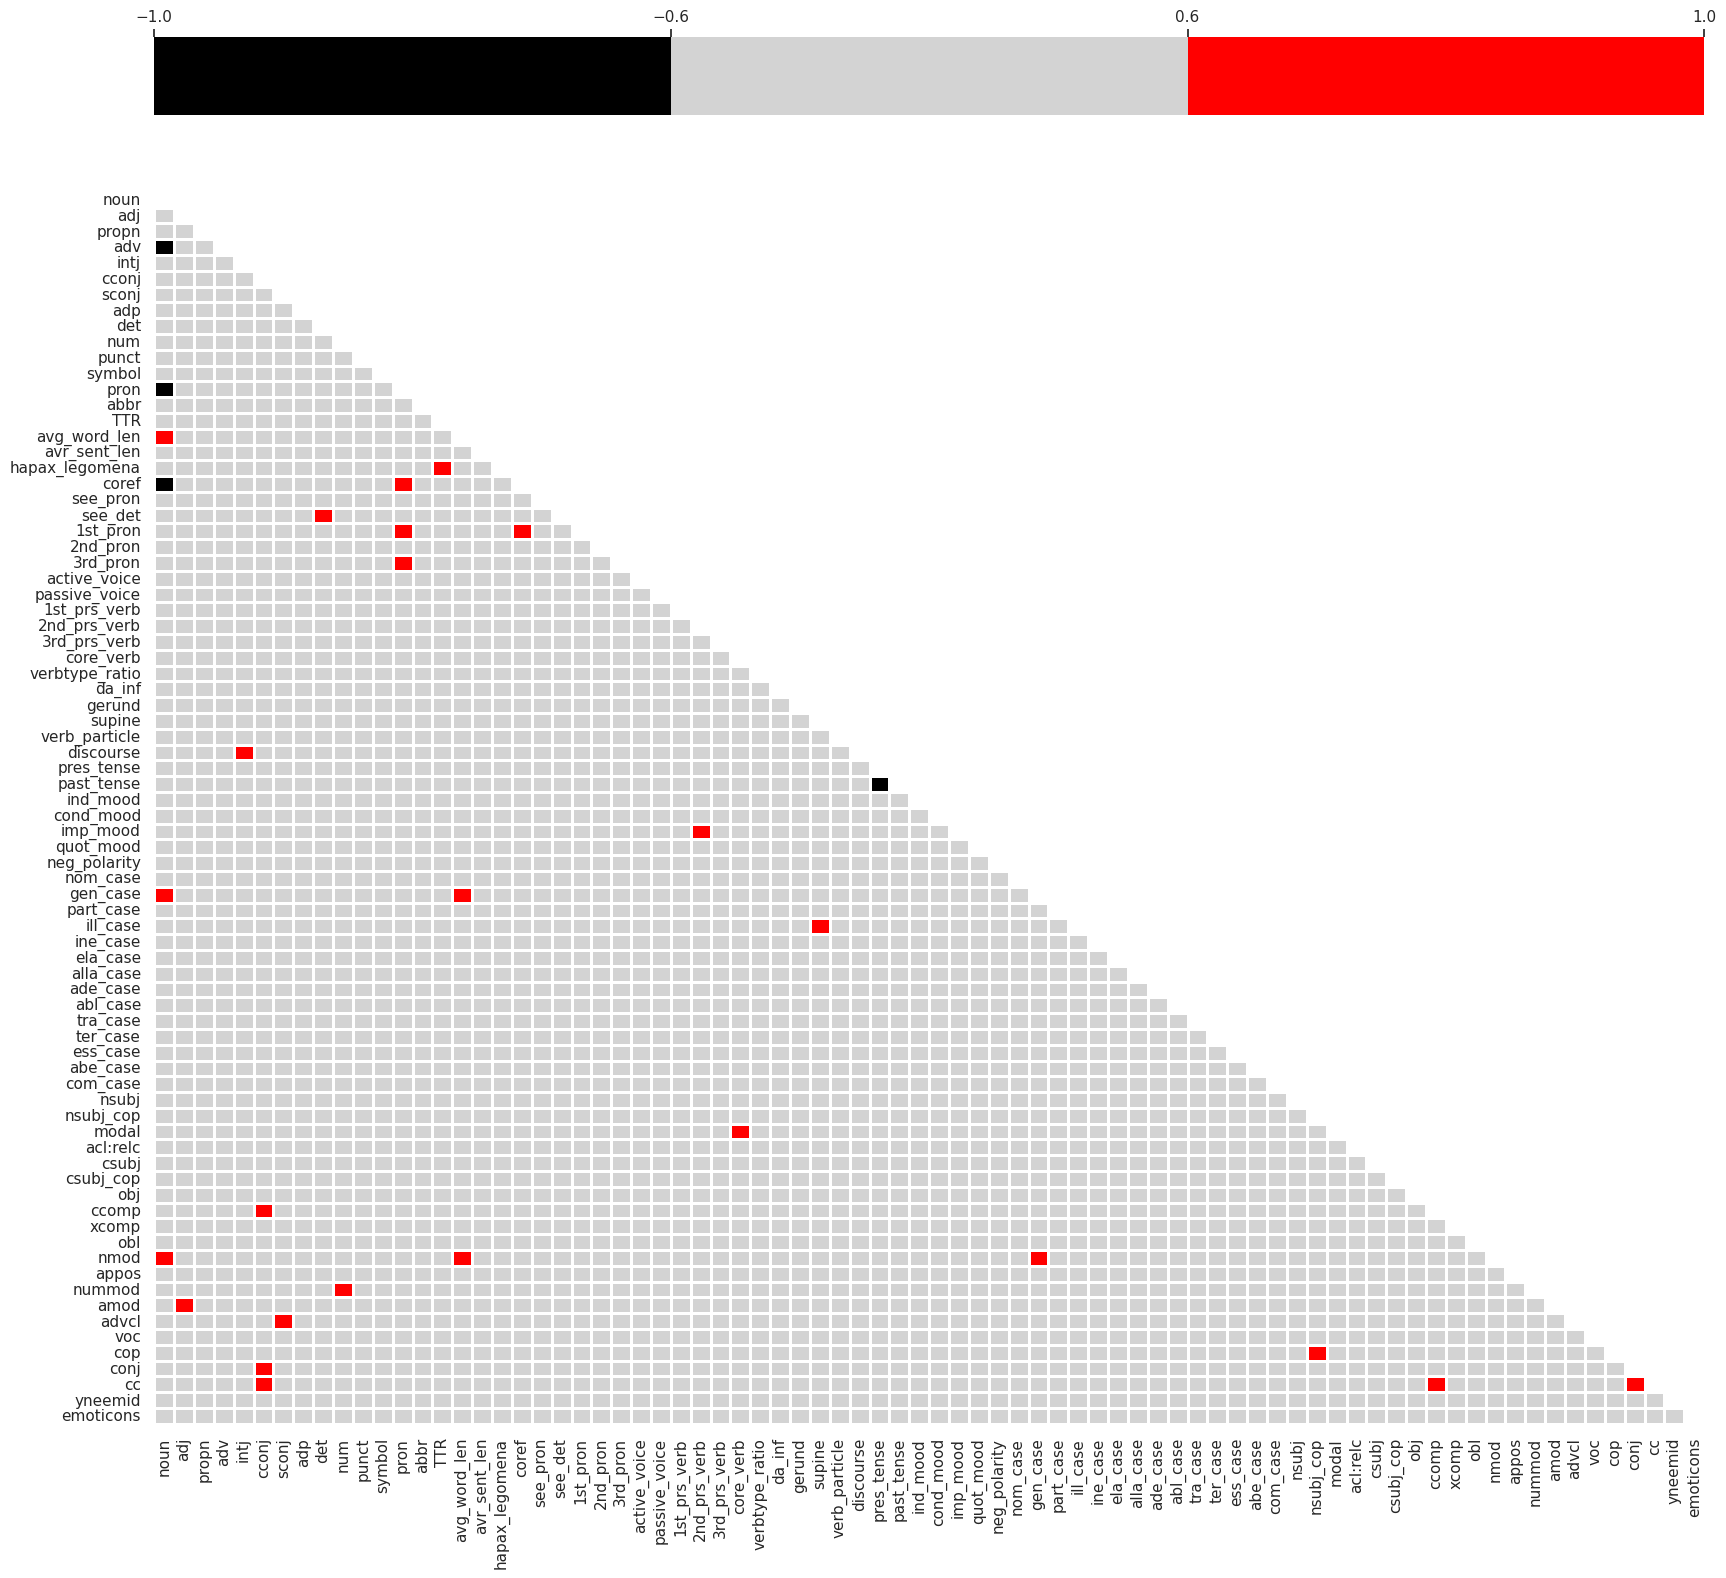

In [32]:
generate_heatmap('all_dims', all_corr)

In [33]:
pairs = get_corr_pairs(all_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

['adv', 'noun'] = -0.64
['noun', 'pron'] = -0.67
['avg_word_len', 'noun'] = 0.71
['coref', 'noun'] = -0.72
['nmod', 'noun'] = 0.68
['adj', 'amod'] = 0.76
['discourse', 'intj'] = 1.0
['ccomp', 'cconj'] = 0.93
['cc', 'cconj'] = 1.0
['advcl', 'sconj'] = 0.65
['det', 'see_det'] = 0.7
['num', 'nummod'] = 0.88
['coref', 'pron'] = 0.91
['1st_pron', 'pron'] = 0.73
['TTR', 'hapax_legomena'] = 0.83
['avg_word_len', 'gen_case'] = 0.62
['avg_word_len', 'nmod'] = 0.67
['1st_pron', 'coref'] = 0.78
['2nd_prs_verb', 'imp_mood'] = 0.98
['core_verb', 'modal'] = 0.66
['ill_case', 'supine'] = 0.72
['past_tense', 'pres_tense'] = -0.77
['gen_case', 'nmod'] = 0.86
['cop', 'nsubj_cop'] = 0.9
['cc', 'ccomp'] = 0.93


## ABSTRAKTNE

In [34]:
abs_df = initial_df['abs']
abs_df
# initial_df[initial_df['abs']<=1]

0      1.35
1      0.65
2      1.25
3      0.60
4      1.15
       ... 
115    0.35
116    0.50
117    0.10
118    0.40
119    1.05
Name: abs, Length: 120, dtype: float64

In [35]:
pos, neg = make_new_df('abs')

print(len(pos), len(neg))

NameError: name 'make_new_df' is not defined

In [ ]:
pos

In [ ]:
abs_corr = pos.corr(method='pearson').round(2)
save_csv('abs', abs_corr)
abs_corr


In [ ]:
generate_heatmap('abs', abs_corr)

In [ ]:
pairs = get_corr_pairs(abs_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


### NORMAALJAOTUS

In [ ]:
def generate_plot(dim, df1, df2, features):
    fig, axs = plt.subplots(ncols=2, figsize=(20, 200))
    plt.subplots_adjust(hspace=0.5)

    for i, feature in enumerate(features):
        df1_mean = np.mean(df1[str(feature)])
        df1_std = np.std(df1[str(feature)])
        pdf1 = stats.norm.pdf(df1[str(feature)].sort_values(), df1_mean, df1_std)
        
        df2_mean = np.mean(df2[str(feature)])
        df2_std = np.std(df2[str(feature)])
        pdf2 = stats.norm.pdf(df2[str(feature)].sort_values(), df2_mean, df2_std)
    
        ax = plt.subplot(40, 2, i+1)
        plt.plot(df1[str(feature)].sort_values(), pdf1, label='>=2')
        plt.plot(df2[str(feature)].sort_values(), pdf2, label='<2')
        plt.legend(loc=1, prop={'size': 20})
        plt.xlabel(str(feature.upper()))

#         plt.savefig(f'normdist_plots/{dim}.pdf')

In [ ]:
generate_plot('abs', pos, neg, feature_names)

### LOGISTILINE REGRESSIOON

In [ ]:
feats = [*feature_names]

In [ ]:
only_abs = initial_df.loc[:, feats + ['abs']].astype('float64')
only_abs['state'] = [1 if score >= 1 else 0 for score in only_abs['abs']]
# print(only_abs)

final_features = only_abs.columns.values.tolist()[:-2]


X = only_abs[final_features]
y = only_abs.state

model = LogisticRegression().fit(X,y)

plot_important_features(model, 'abstraktsus')


In [ ]:

log_reg = smf.logit("state ~ coref + hapax_legomena + noun + nom_case + avg_word_len + past_tense + pres_tense + obl + adv + num + ade_case + nummod + part_case", data=only_abs).fit()
log_reg.summary()

# AFEKTIIVNE

In [ ]:
dim = 'afek'

In [ ]:
pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:


dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['afek']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['afek']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'afektiivsus')

In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + noun + adv + pron + verbtype_ratio + TTR + punct + active_voice + adj + conj + avr_sent_len", data=df).fit()
log_reg.summary()

## AEG

In [ ]:
dim = 'aeg'
pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)

pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)


In [ ]:
df = initial_df.loc[:, feats + ['aeg']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['aeg']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'aeg')

In [ ]:
log_reg = smf.logit("state ~ coref + past_tense + pres_tense + obl + verbtype_ratio + adv + num + avg_word_len + gen_case + nummod + noun + core_verb + ade_case + propn + da_inf + cop", data=df).fit()
log_reg.summary()

## ARGUMENTATIIVNE

In [ ]:
dim = 'arg'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['arg']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['arg']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'arg')



In [ ]:
log_reg = smf.logit("state ~ coref + hapax_legomena + propn + verbtype_ratio + past_tense + pres_tense + avg_word_len + gen_case + conj + TTR + adj + neg_polarity + obl + part_case", data=df).fit()
log_reg.summary()

## FORMAALNE

In [ ]:
dim = 'form'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)

pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['form']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['form']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'formaalsus')




In [ ]:

log_reg = smf.logit("state ~ avg_word_len + coref + gen_case + noun + obl + adv + nmod + num", data=df).fit()
log_reg.summary()

## IMPERSONAALNE

In [ ]:
dim = 'imp'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['imp']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['imp']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'impersonaalsus')





In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + noun + past_tense + pres_tense + conj + pron + num", data=df).fit()
log_reg.summary()

## INFO

In [ ]:
dim = 'info'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['info']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['info']]

final_features = df.columns.values.tolist()[:-2]

X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'info')


In [ ]:

log_reg = smf.logit("state ~ coref + num + avg_word_len + active_voice + propn + nummod + pron + ind_mood + hapax_legomena + nsubj", data=df).fit()
log_reg.summary()

## INSTRUEERIV

In [ ]:
dim = 'inst'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['inst']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['inst']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'instrueerivus')


In [ ]:
log_reg = smf.logit("state ~ coref + pres_tense + nom_case + pron + hapax_legomena + past_tense + verbtype_ratio + noun + third_prs_verb + second_prs_verb + imp_mood + pron", data=df).fit()
log_reg.summary()

## INTERAKTIIVNE

In [ ]:
dim = 'inter'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['inter']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['inter']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'inter')

In [ ]:
log_reg = smf.logit("state ~ avg_word_len + hapax_legomena + TTR + gen_case + noun + verbtype_ratio + avr_sent_len", data=df).fit()
log_reg.summary()

## KEER

In [ ]:
dim = 'keer'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['keer']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['keer']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'keerulisus')

In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + hapax_legomena + verbtype_ratio + abbr + nmod + past_tense + obl + active_voice", data=df).fit()
log_reg.summary()

## SPONT

In [ ]:
dim = 'spont'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)

pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['spont']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['spont']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'spontaansus')





In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + noun + gen_case + nom_case + avr_sent_len + obl + propn", data=df).fit()
log_reg.summary()

## SUBJ

In [ ]:
dim = 'subj'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['subj']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['subj']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'subjektiivsus')





In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + verbtype_ratio + adv + propn + noun", data=df).fit()
log_reg.summary()